In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.models.DCVC_net import DCVC_net
import torch
from torchvision import transforms
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
import wandb
import tqdm
import torchnet.meter as meter


/home/jatin/miniconda3/envs/DCVC/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
LAMBDA = 2048
BATCH_SIZE = 4
DATA_DIR = pathlib.Path('/data2/jatin/vimeo_septuplet/sequences')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [5]:
video_net = DCVC_net(up_strategy='default')

In [6]:
# load the good weights
# video_net.opticFlow = torch.load('../DCVC/optflow.pth')
# video_net.mvEncoder = torch.load('../DCVC/mvenc.pth')
# video_net.mvDecoder_part1 = torch.load('../DCVC/mvDecoder_part1.pth')
# video_net.mvDecoder_part2 = torch.load('../DCVC/mvDecoder_part2.pth')
# video_net.feature_extract = torch.load('../DCVC/feature_extract.pth')
# video_net.context_refine = torch.load('../DCVC/context_refine.pth')

chpt = torch.load('dcvc-b-frame-from-epoch4-from-no-lamb-lambda-2048/dcvc_epoch=2_psnr=0.4061_bpp=0.1407.pt')
# chpt = torch.load('dcvc-b-frame-with-bitrate/dcvc_epoch=2_int_allquantize.pt')
# chpt = torch.load('dcvc-b-frame-with-bitrate-lambda-2048-tryfix-bitrate/dcvc_epoch=3_int_0.05bpp_40.65psnr.pt')
# chpt = torch.load('dcvc-b-frame-with-bitrate-lambda-2048-tryfix-bitrate/dcvc_epoch=2_int_allquantize.pt')
video_net.load_state_dict(chpt['model'], strict=True)

# temporalPriorEncoder = video_net.temporalPriorEncoder
# del video_net.temporalPriorEncoder
# chpt = torch.load('dcvc-b-frame-convtranspose-fail/dcvc_epoch=4_int.pt')
# video_net.load_state_dict(chpt['model'], strict=False)
# video_net.temporalPriorEncoder = temporalPriorEncoder

video_net = video_net.to(DEVICE)
# optimizer = torch.optim.Adam(video_net.parameters(), lr=wandb.config.learning_rate)
# optimizer.load_state_dict(chpt['optimizer'])

# video_net.opticFlow.requires_grad_ = False
# video_net.mvEncoder.requires_grad_ = False
# video_net.mvDecoder_part1.requires_grad_ = False
# video_net.mvDecoder_part2.requires_grad_ = False
# video_net.feature_extract.requires_grad_ = False
# video_net.context_refine.requires_grad_ = False

In [7]:
optimizer = torch.optim.Adam(video_net.parameters(), lr=1e-4)
optimizer.load_state_dict(chpt['optimizer'])
del chpt

In [8]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, crop_size=256, make_b_cut=True, deterministic=False):
        self.data_dir = data_dir
        self.crop_size = crop_size
        self.make_b_cut = make_b_cut
        self.deterministic = deterministic
        self.all_paths = []
        for seq in os.listdir(self.data_dir):
            subseq = os.listdir(self.data_dir / seq)
            for s in subseq:
                self.all_paths.append(self.data_dir / seq / s)
        assert len(self.all_paths) == 91701
        
        self.transforms = torch.nn.Sequential(
            transforms.RandomCrop(crop_size)
        )
       
    def __getitem__(self, i):
        path = self.all_paths[i]
        imgs = []
        if self.make_b_cut:
            # load two reference frames and the B-frame in the middle
            #TODO: implement making this deterministic
            interval = np.random.randint(1, 4) # can be 1, 2, or 3
            ref1 = plt.imread(path / f'im{1}.png')
            ref2 = plt.imread(path / f'im{1 + interval*2}.png')
            # this is the B-frame, in the middle
            im = plt.imread(path / f'im{1 + interval}.png')
            imgs = [ref1, ref2, im]
        else:
            # load full sequence
            for i in range(1, 8):
                # should be between [0, 1]
                img = plt.imread(path / f'im{i}.png')
        
        # plt.imread should make inputs in [0, 1] for us
        imgs = np.stack(imgs, axis=0)
        # bring RGB channels in front
        imgs = imgs.transpose(0, 3, 1, 2)
        return self.transforms(torch.FloatTensor(imgs))

    def __len__(self):
        return len(self.all_paths)

ds = VideoDataset(DATA_DIR)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=6,
    prefetch_factor=5
)

In [9]:
criterion = torch.nn.MSELoss()

In [10]:
def count_parameters(model):
    """Return number of parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(video_net)} trainable parameters')

The model has 10622976 trainable parameters


In [11]:
def square_and_reduce(x):
    sq = x**2
    diff = (sq - x).detach()
    return sq - diff

In [12]:
def train_epoch(model, epoch, dl, optimizer, criterion, use_lambda=True):
    model.train()

    loss_meter = meter.AverageValueMeter()
    mse_meter = meter.AverageValueMeter()
    bpp_meter = meter.AverageValueMeter()
    bpp_mv_y_meter = meter.AverageValueMeter()
    bpp_mv_z_meter = meter.AverageValueMeter()
    bpp_y_meter = meter.AverageValueMeter()
    bpp_z_meter = meter.AverageValueMeter()
    
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, x in enumerate(pbar):
        x = x.to(DEVICE)
        ref1 = x[:,0]
        ref2 = x[:,1]
        im = x[:,2]
        preds_dict = model(ref1, ref2, im, compress_type='train_compress')
        preds = preds_dict['recon_image']
        bpp = preds_dict['bpp']
        mse_loss = criterion(preds, im)
        mse_ls = mse_loss.item()
        avg_mse = mse_meter.value()[0]
        if not np.isnan(avg_mse) and avg_mse < 0.001 and mse_ls > 0.1:
            # waits until average loss is pretty low
            print('REALLY BAD LOSS', mse_ls)
            wandb.alert(
                title="High Loss", 
                text=f"Loss {mse_ls} is way above the threshold"
            )
            return None, True, x
#         if use_lambda:
#             bpp_mv_y = preds_dict['bpp_mv_y']
#             bpp_mv_z = preds_dict['bpp_mv_z']
#             bpp_y = preds_dict['bpp_y']
#             bpp_z = preds_dict['bpp_z']
# #             bpp = square_and_reduce(bpp_y) + square_and_reduce(bpp_z) + square_and_reduce(bpp_mv_y) + square_and_reduce(bpp_mv_z)
#             loss = mse_loss * LAMBDA + bpp
# #             loss = mse_loss * LAMBDA + preds_dict['bpp_y']
#         else:
#             loss = mse_loss
        loss = bpp
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        ls = loss.item()
        loss_meter.add(ls)
        mse_meter.add(mse_ls)
        bpp_meter.add(bpp.item())
        bpp_mv_y_meter.add(preds_dict['bpp_mv_y'].item())
        bpp_mv_z_meter.add(preds_dict['bpp_mv_z'].item())
        bpp_y_meter.add(preds_dict['bpp_y'].item())
        bpp_z_meter.add(preds_dict['bpp_z'].item())
        if i % 1 == 0:
            avg_psnr = round(-10.0*np.log10(mse_meter.value()[0]), 6)
            avg_bpp = round(bpp_meter.value()[0], 6)
            avg_bpp_mv_y = round(bpp_mv_y_meter.value()[0], 6)
            avg_bpp_mv_z = round(bpp_mv_z_meter.value()[0], 6)
            avg_bpp_y = round(bpp_y_meter.value()[0], 6)
            avg_bpp_z = round(bpp_z_meter.value()[0], 6)
            msg = (
                f'Avg PSNR: {avg_psnr}, bpp: {avg_bpp}, bpp_mv_y: {avg_bpp_mv_y}, avg_bpp_mv_z: {avg_bpp_mv_z} '
                f'avg_bpp_y: {avg_bpp_y}, avg_bpp_z: {avg_bpp_z}'
            )
            pbar.set_description(msg)
    return loss_meter.value()[0], False, None

            

In [13]:
avg_loss, had_err, err_x = train_epoch(video_net, 1, dl, optimizer, criterion)

Avg PSNR: 26.690283, bpp: 0.024786, bpp_mv_y: 0.01778, avg_bpp_mv_z: 0.000714 avg_bpp_y: 0.005712, avg_bpp_z: 0.000581:   2%|▏         | 532/22926 [03:47<2:39:57,  2.33it/s] 


KeyboardInterrupt: 

In [12]:
LAMBDA = 1024

In [13]:
avg_loss, had_err, err_x = train_epoch(video_net, 1, dl, optimizer, criterion)

Avg PSNR: 40.460191, bpp: 0.111866, bpp_mv_y: 0.029431, avg_bpp_mv_z: 0.000898 avg_bpp_y: 0.08039, avg_bpp_z: 0.001147:   1%|          | 215/22926 [01:43<3:01:47,  2.08it/s] 


KeyboardInterrupt: 

In [12]:
avg_loss, had_err, err_x = train_epoch(video_net, 1, dl, optimizer, criterion)

Avg PSNR: 40.754851, bpp: 0.102224, bpp_mv_y: 0.028361, avg_bpp_mv_z: 0.00086 avg_bpp_y: 0.071845, avg_bpp_z: 0.001159:   0%|          | 98/22926 [00:47<3:03:58,  2.07it/s] 


KeyboardInterrupt: 

In [12]:
avg_loss, had_err, err_x = train_epoch(video_net, 1, dl, optimizer, criterion)

Avg PSNR: 40.888405, bpp: 0.198126, bpp_mv_y: 0.033096, avg_bpp_mv_z: 0.000896 avg_bpp_y: 0.162716, avg_bpp_z: 0.001417:   0%|          | 27/22926 [00:14<3:23:05,  1.88it/s]


KeyboardInterrupt: 

In [ ]:
USE_LAMBDA = True
print("USE LAMBDA", USE_LAMBDA)
for i in range(1, wandb.config.epochs + 1):
    avg_loss, had_err, err_x = train_epoch(video_net, i, dl, optimizer, criterion, use_lambda=USE_LAMBDA)
    if had_err:
        print('Breaking out of train loop for debugging...')
        break
    torch.save(
        {'model': video_net.state_dict(), 'optimizer': optimizer.state_dict()},
        SAVE_FOLDER / f"dcvc_epoch={i}_avg_loss={avg_loss}.pt",
    )
    

USE LAMBDA True


Avg PSNR/Bitrate, Batch Loss: (40.893612, 0.155758, 0.348006):   6%|▌         | 1271/22926 [10:04<2:50:28,  2.12it/s]

In [19]:
torch.save(
        {'model': video_net.state_dict(), 'optimizer': optimizer.state_dict()},
        SAVE_FOLDER / f"dcvc_epoch={i}_psnr=0.4061_bpp=0.1407.pt",
)

In [16]:
preds_x_np = preds.detach().cpu().numpy()

In [17]:
preds_x_np.shape

(4, 3, 256, 256)

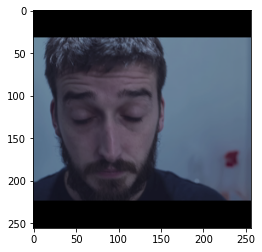

In [18]:
plt.imshow(np.clip(err_x_np[2,2].transpose(1,2,0), 0.0, 1.0))

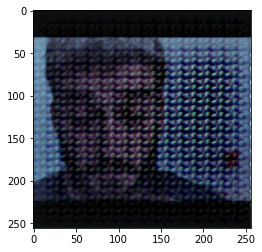

In [19]:
plt.imshow(np.clip(preds_x_np[2].transpose(1,2,0), 0.0, 1.0))

In [1]:
wandb.finish()

NameError: name 'wandb' is not defined